<a href="https://colab.research.google.com/github/sterlinggutterman/labs/blob/main/SG_web_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

## 1. Pick something on Craigslist: **Sporting Equipment**. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'} # my personal user agent
url = 'https://charlottesville.craigslist.org/search/sga#search=1~gallery~0~0' # CL sports data
raw = requests.get(url,headers=header) # Get page

### ***Initial Observations***

Categories
- variety of sports represented
- essential equipment and accessories
- exercise machines
- storage equipment
- sports memorabilia
- shoes
- camping supplies

Conditions to investigate
- year
- quality
- price
- location

Questions
- How many listings are there in each category?
- What is the price distribution in each category? What category has the most expensive item?
- What are the newest and oldest items being sold?
- What is the relationship between price and quality in each category?
- What are the best items in Charlottesville?

# 2. Get your search results of interest and extract data from them

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

In [ ]:
# understanding what the parsed data looks like and what I want to extract from it
print(listings)

In [3]:
# isolating words from the listings to create categories based on sports
categories = ['heater', 'sticks', 'baseball', 'bike', 'chairs', 'table', 'bow',
              'exercise', 'golf', 'gun', 'shoes', 'iron', 'bag', 'clubs', 'gym',
              'pool', 'surf', 'tennis', 'camera', 'pack', 'putter', 'driver',
              'aerobic', 'elliptical', 'kayak', 'woods', 'weight', 'banner',
              'trainer', 'ski', 'reel', 'strength', 'treadmill', 'hyrbid',
              'squat', 'catcher', 'trainer']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get sport from the title string:
    words = title.split()
    hits = [word for word in words if word in categories]
    if len(hits) == 0:
        sport = 'missing'
    else:
        sport = hits[0]
    # Get location from title string:
    location_div = listings[k].find('div', class_='location')
    if location_div: # if location is found
        location = location_div.get_text().strip()
    else: # if location is missing
        location = np.nan
    data.append({'title':title,'price':price,'link':link,'location':location,'sport':sport})

# 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce') # turn price into numeric
df['location'] = df['location'].str.replace('(','')
df['location'] = df['location'].str.replace(')','')
# streamline locations
df.loc[df['location'].str.contains('Charlottesville', case=False, na=False), 'location'] = 'Charlottesville'
df.loc[df['location'].str.contains('Albemarle', case=False, na=False), 'location'] = 'Albemarle'
df.loc[df['location'].str.contains('Gordonsville', case=False, na=False), 'location'] = 'Gordonsville'
df.loc[df['location'].str.contains('Palmyra', case=False, na=False), 'location'] = 'Palmyra'
df.loc[df['location'].str.contains('lake', case=False, na=False), 'location'] = 'Lake Monticello'
# streamlining sports
df.loc[df['sport'].isin(['golf', 'clubs', 'iron', 'putter', 'woods', 'driver', 'hybrid']), 'sport'] = 'golf' # combine all values into golf category
df.loc[df['sport'].isin(['exercise', 'gym', 'aerobic', 'elliptical', 'weight', 'trainer', 'strength', 'treadmill', 'squat', 'trainer']), 'sport'] = 'exercise' # combine all values into exercise category
df.loc[df['sport'].isin(['bags', 'pack']),'sport'] = 'bags' # combine all values into bag category
df.loc[df['sport'].isin(['baseball', 'catcher']),'sport'] = 'baseball' # combine all values into baseball category
df = df.loc[df['sport'] != 'missing'] # remove values where sport is missing
# some sports only had one listing and other items could not be categorized
print(df.shape)
df.to_csv('craigslist_cville_sports.csv') # save data
df.head()

(124, 5)


,title,price,link,location,sport
0,golf bag radio/phone,25,https://charlottesville.craigslist.org/spo/d/m...,Gordonsville,golf
2,stealth cam stc-1590 outdoor trail digital camera,45,https://charlottesville.craigslist.org/spo/d/c...,Culpeper,camera
4,(2) karate staff/poles storage bag,50,https://charlottesville.craigslist.org/spo/d/t...,Louisa,bag
6,large sleeping bag,20,https://charlottesville.craigslist.org/spo/d/t...,NaN,bag
7,green sleeping bag,10,https://charlottesville.craigslist.org/spo/d/t...,NaN,bag


#### ***Visualizations***

In [5]:
# isolating specific sport categories
print(df[df['sport']=='golf'])
print(df[df['sport']=='exercise'])

                                              title  price  \
0                              golf bag radio/phone     25   
28                     golf tee set & emergency kit      7   
36                 kid youth golf club set with bag      0   
38            stocking stuffer christmas golf balls      2   
48                callaway golf drivers - gb bertha     30   
50                            wilson large golf bag     85   
52                  addidas golf shoes - 12.5 men's     22   
54                                    nike golf bag     45   
56                              ping anser 2 putter     40   
57                          golfdom travel golf bag     40   
58                            honma fe-400 iron set    220   
59                            taylor made r7 driver     45   
60                            odyssey 2-ball putter     35   
66   titleist, callaway, and bridgestone golf balls      0   
79                                 exotics golf bag     50   
80      

Observations
- Most expensive golf item is the Yamaha electric golf cart
- There are lots of golfers in Charlottesville
- There are lots of different pieces of equipment involved in golf
- The most expensive exercise items are the treadmills and trainers
- Exercise is generally very expensive

In [6]:
# summary stats:
print(df['price'].describe())
print(df['location'].describe())
print(df['sport'].describe())

count     124.000000
mean      156.677419
std       332.017277
min         0.000000
25%        22.000000
50%        45.000000
75%       125.000000
max      2400.000000
Name: price, dtype: float64
count                 111
unique                 31
top       Charlottesville
freq                   52
Name: location, dtype: object
count      124
unique      19
top       golf
freq        42
Name: sport, dtype: object


In [7]:
# price by sport:
df.loc[:,['price','sport']].groupby('sport').describe().sort_values(by=('price','count'), ascending=False)

price                                                              
         count        mean         std   min     25%    50%      75%     max
sport                                                                       
golf      42.0  112.452381  365.382406   0.0   26.25   40.0    78.75  2400.0
exercise  14.0  450.642857  292.199249  10.0  243.75  500.0   575.00   999.0
tennis     8.0   47.125000   33.150900  22.0   28.75   40.0    43.75   125.0
baseball   8.0    4.375000   12.374369   0.0    0.00    0.0     0.00    35.0
bow        8.0  127.500000  136.460355  10.0   72.50   90.0   112.50   450.0
reel       8.0   60.625000   55.513029  10.0   18.75   32.5   106.25   150.0
bike       7.0  226.428571  231.835327  15.0   87.50  150.0   272.50   700.0
bag        6.0   70.833333  103.654072  10.0   20.00   32.5    48.75   280.0
kayak      4.0  754.750000  952.157331   0.0   15.00  509.5  1249.25  2000.0
table      4.0  205.000000  330.100995  30.0   37.50   45.0   212.50   700.0
banner     3.0   23.333333    2.886751  20.0   22.50   25.0    25.00    25.0
heater     2.0   60.000000   35.355339  35.0   47.50   60.0    72.50    85.0
pool       2.0  100.000000   70.710678  50.0   75.00  100.0   125.00   150.0
camera     2.0   40.000000    7.071068  35.0   37.50   40.0    42.50    45.0
ski        2.0   40.000000   55.154329   1.0   20.50   40.0    59.50    79.0
chairs     1.0    0.000000         NaN   0.0    0.00    0.0     0.00     0.0
shoes      1.0   60.000000         NaN  60.0   60.00   60.0    60.00    60.0
sticks     1.0   10.000000         NaN  10.0   10.00   10.0    10.00    10.0
gun        1.0   10.000000         NaN  10.0   10.00   10.0    10.00    10.0

Observations

- Golf had the most amount of listings
- Kayaks are the most expensive individual items but have a very large deviation between values
- Exercise equipment is also very expensive and has less of a deviation

In [8]:
# price by location:
df.loc[:,['price','location']].groupby('location').describe().sort_values(by=('price','count'), ascending=False)

price                                                   \
                     count         mean          std    min     25%     50%   
location                                                                      
Charlottesville       52.0    92.307692   132.359217    0.0   30.00    40.0   
Ruckersville           5.0   447.000000   869.939653    0.0   35.00    50.0   
Culpeper               4.0    33.750000    16.520190   10.0   28.75    40.0   
Louisa                 4.0   162.750000   228.437263    1.0   37.75    75.0   
Scottsville            4.0   388.750000   282.322953   35.0  248.75   410.0   
Orange                 4.0   231.250000   346.322947   35.0   53.75    70.0   
Foxcroft               3.0    21.666667     7.637626   15.0   17.50    20.0   
Madison                3.0   225.000000   195.256242  100.0  112.50   125.0   
Troy                   3.0   343.333333   397.030645   80.0  115.00   150.0   
Crozet                 3.0   300.000000   350.000000   50.0  100.00   150.0   
Gordonsville           2.0  1212.500000  1679.378605   25.0  618.75  1212.5   
Albemarle              2.0    38.000000    52.325902    1.0   19.50    38.0   
Lake Monticello        2.0     8.500000     2.121320    7.0    7.75     8.5   
Free Union             2.0   574.500000   600.333657  150.0  362.25   574.5   
Schuyler               2.0   130.000000   134.350288   35.0   82.50   130.0   
Rockville              1.0   150.000000          NaN  150.0  150.00   150.0   
Rio rd                 1.0    20.000000          NaN   20.0   20.00    20.0   
Staunton               1.0   450.000000          NaN  450.0  450.00   450.0   
Zion Crossroads        1.0    35.000000          NaN   35.0   35.00    35.0   
Palmyra                1.0   100.000000          NaN  100.0  100.00   100.0   
315 Willow Lawn Dr.    1.0    85.000000          NaN   85.0   85.00    85.0   
Nelson                 1.0    20.000000          NaN   20.0   20.00    20.0   
Lexington              1.0     0.000000          NaN    0.0    0.00     0.0   
Keswick                1.0   125.000000          NaN  125.0  125.00   125.0   
Fredericksburg         1.0    79.000000          NaN   79.0   79.00    79.0   
Four Seasons           1.0    10.000000          NaN   10.0   10.00    10.0   
Earlysville            1.0     2.000000          NaN    2.0    2.00     2.0   
Dyke/Nortonsville Va   1.0    75.000000          NaN   75.0   75.00    75.0   
Brightwood             1.0    80.000000          NaN   80.0   80.00    80.0   
Barboursville          1.0    10.000000          NaN   10.0   10.00    10.0   
spotsylvania           1.0    40.000000          NaN   40.0   40.00    40.0   

                                       
                          75%     max  
location                               
Charlottesville         86.25   600.0  
Ruckersville           150.00  2000.0  
Culpeper                45.00    45.0  
Louisa                 200.00   500.0  
Scottsville            550.00   700.0  
Orange                 247.50   750.0  
Foxcroft                25.00    30.0  
Madison                287.50   450.0  
Troy                   475.00   800.0  
Crozet                 425.00   700.0  
Gordonsville          1806.25  2400.0  
Albemarle               56.50    75.0  
Lake Monticello          9.25    10.0  
Free Union             786.75   999.0  
Schuyler               177.50   225.0  
Rockville              150.00   150.0  
Rio rd                  20.00    20.0  
Staunton               450.00   450.0  
Zion Crossroads         35.00    35.0  
Palmyra                100.00   100.0  
315 Willow Lawn Dr.     85.00    85.0  
Nelson                  20.00    20.0  
Lexington                0.00     0.0  
Keswick                125.00   125.0  
Fredericksburg          79.00    79.0  
Four Seasons            10.00    10.0  
Earlysville              2.00     2.0  
Dyke/Nortonsville Va    75.00    75.0  
Brightwood              80.00    80.0  
Barboursville           10.00    10.0  
spotsylvania  

Observations
- Gordonsville has the most expensive listing
- Charlottesville items are averagely priced for sporting equipment
- Ruckersville and Staunton have high means and standard deviations

In [10]:
# sport by location:
df.loc[:,['sport','location']].groupby('location').describe().sort_values(by=('sport','count'), ascending=False)

sport                      
                     count unique       top freq
location                                        
Charlottesville         52      9      golf   28
Ruckersville             5      4      golf    2
Culpeper                 4      4    camera    1
Louisa                   4      4       bag    1
Scottsville              4      4     table    1
Orange                   4      4     shoes    1
Foxcroft                 3      3     table    1
Madison                  3      2      reel    2
Troy                     3      3      reel    1
Crozet                   3      3      pool    1
Gordonsville             2      1      golf    2
Albemarle                2      1      golf    2
Lake Monticello          2      2      golf    1
Free Union               2      2       bow    1
Schuyler                 2      2      golf    1
Rockville                1      1      golf    1
Rio rd                   1      1     kayak    1
Staunton                 1      1  exercise    1
Zion Crossroads          1      1  exercise    1
Palmyra                  1      1      bike    1
315 Willow Lawn Dr.      1      1    heater    1
Nelson                   1      1      reel    1
Lexington                1      1     kayak    1
Keswick                  1      1    tennis    1
Fredericksburg           1      1       ski    1
Four Seasons             1      1  exercise    1
Earlysville              1      1      golf    1
Dyke/Nortonsville Va     1      1      bike    1
Brightwood               1      1       bow    1
Barboursville            1      1       bow    1
spotsylvania             1      1     table    1

Observations
- Charlottesville has the most sport variety
- Golf appears in many locations

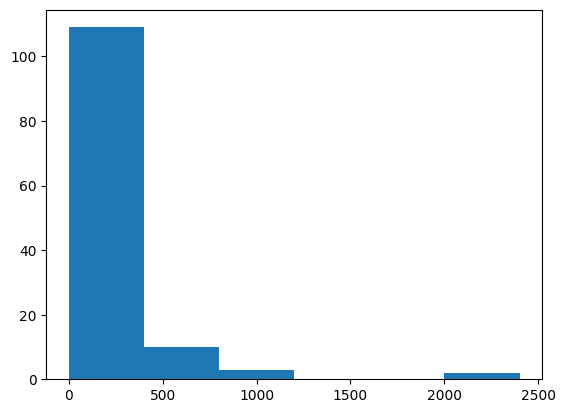

In [19]:
# price graph
df['price'].hist(grid=False, bins=6)
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

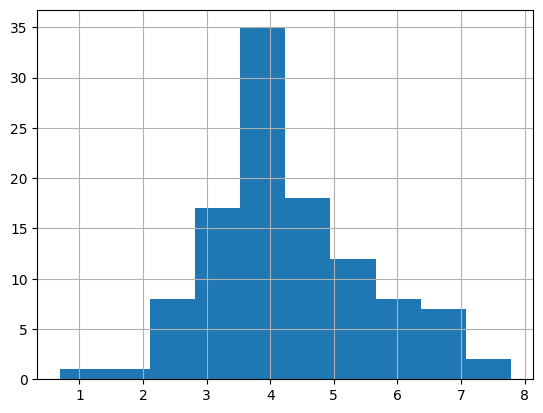

In [24]:
df['price_log'] = np.log(df['price'])
df.loc[df['price_log']>0,'price_log'].hist()

log of price shows a more normal distribution

location
Charlottesville         52
Ruckersville             5
Louisa                   4
Scottsville              4
Culpeper                 4
Orange                   4
Foxcroft                 3
Troy                     3
Crozet                   3
Madison                  3
Gordonsville             2
Albemarle                2
Free Union               2
Lake Monticello          2
Schuyler                 2
Staunton                 1
Zion Crossroads          1
Rio rd                   1
Fredericksburg           1
Brightwood               1
Keswick                  1
Four Seasons             1
Rockville                1
Lexington                1
315 Willow Lawn Dr.      1
Earlysville              1
spotsylvania             1
Dyke/Nortonsville Va     1
Palmyra                  1
Nelson                   1
Barboursville            1
Name: count, dtype: int64 

Axes(0.125,0.11;0.775x0.77) 



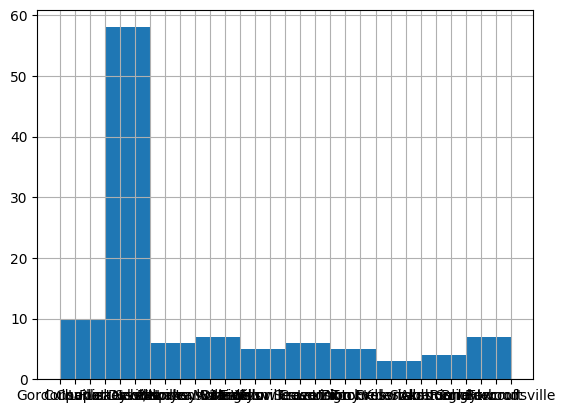

In [20]:
# location graph
print(df['location'].value_counts(),'\n')
print(df['location'].hist(), '\n')

sport
golf        42
exercise    14
bow          8
tennis       8
reel         8
baseball     8
bike         7
bag          6
kayak        4
table        4
banner       3
camera       2
heater       2
pool         2
ski          2
chairs       1
gun          1
shoes        1
sticks       1
Name: count, dtype: int64 

Axes(0.125,0.11;0.775x0.77) 



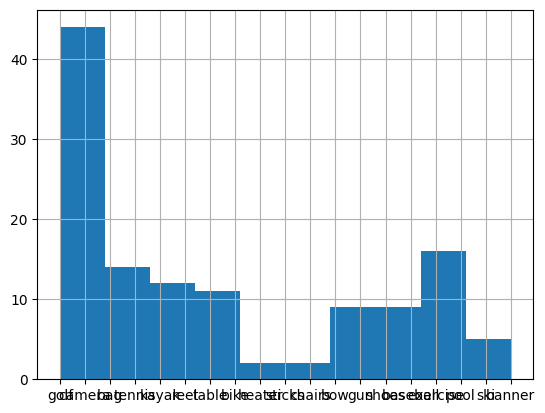

In [21]:
# sport graph
print(df['sport'].value_counts(),'\n')
print(df['sport'].hist(), '\n')

<Axes: xlabel='sport', ylabel='price'>

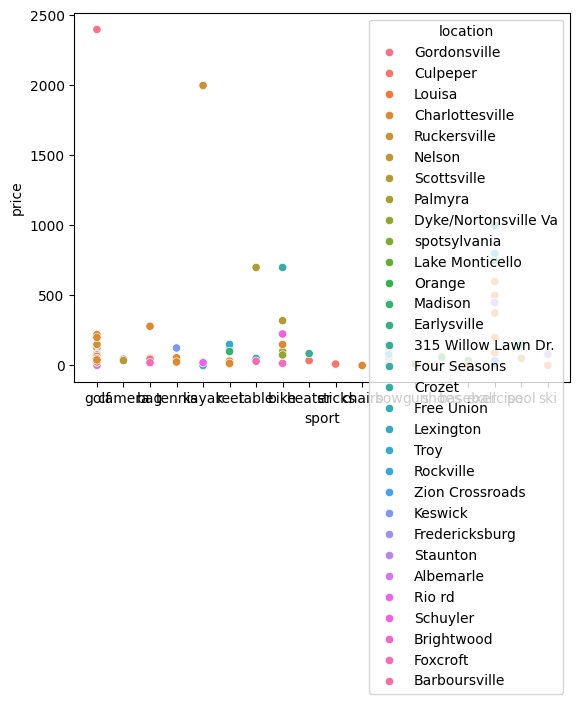

In [22]:
# price by sport and location
sns.scatterplot(data=df, x='sport', y='price',hue='location')

Observations
- Hard to tell exactly what is happening, so no grand conclusions can be made about sports listing in these different areas
- Aligned with the tables, golf and Charlottesville have the most values